In [1]:
import numpy as np
import ephem
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import datetime
import pandas as pd
import scipy as sp
import scipy.signal as sig
import scipy.interpolate as interp

In [2]:
def get_sec(dtime):
    return dtime.hour * 3600 + dtime.minute * 60 + dtime.second
def get_hour(dtime):
    return get_sec(dtime)/3600
def temp2hr(temp):
    return temp*24/100
def smooth(data, Nfilt=101):
    N = len(data)
    fitdat = np.tile(data,3)
    filt = sig.savgol_filter(fitdat, Nfilt, 3)
    out = np.array([max(0,x) for x in filt[N:2*N]])
    return out
def plot_daynight(ax, theta, sunrise, sunset, roffset, alpha=0.2):
    top = np.ones_like(theta)*24 + roffset
    bottom = np.ones_like(theta)*0+roffset
    ax.fill_between(theta, bottom, np.concatenate((sunrise,np.reshape(sunrise[0], (1,))))+roffset, facecolor='black', alpha=alpha, zorder=1.5)
    ax.fill_between(theta, np.concatenate((sunset,np.reshape(sunset[0], (1,))))+roffset, top, facecolor='black', alpha=alpha, zorder=1.5)

def plot_equinoxes(ax, theta, roffset):
    dth = theta[1]-theta[0]
    seq = (datetime.date(2017,3,20)-datetime.date(2017,1,1)).days
    ssol = (datetime.date(2017,6,20)-datetime.date(2017,1,1)).days
    feq = (datetime.date(2017,9,22)-datetime.date(2017,1,1)).days
    wsol = (datetime.date(2017,12,21)-datetime.date(2017,1,1)).days

    ax.plot(np.array([dth, dth])*seq, np.array([0,24])+roffset,'k--')
    ax.plot(np.array([dth, dth])*ssol, np.array([0,24])+roffset,'k--')
    ax.plot(np.array([dth, dth])*feq, np.array([0,24])+roffset,'k--')
    ax.plot(np.array([dth, dth])*wsol, np.array([0,24])+roffset,'k--')
def plot_moon(ax, theta, moonrise, moonset, moonphase, roffset):
    for i in range(min(len(moonrise),len(moonset))):
        if moonrise[i] < moonset[i]:
            start = moonrise[i]+roffset
            end = moonset[i]+roffset
            ax.plot([theta[i], theta[i]], [start,end],'k', alpha=moonphase[i])
        else:
            start=0+roffset
            end = moonset[i]+roffset
            ax.plot([theta[i], theta[i]], [start,end],'k', alpha=moonphase[i])
            start = moonrise[i]+roffset
            end = 24+roffset
            ax.plot([theta[i], theta[i]], [start,end],'k', alpha=moonphase[i])
def plot_line(ax, theta, data, roffset, color):
    toplt = np.concatenate((data,np.reshape(data[0], (1,))))
    ax.plot(theta, toplt+roffset, color, linewidth=4)
    
def filter_rise(lin):    
    for i in range(1,len(lin)):
        try:
            if lin[i] == lin[i-1]:
                lin.pop(i)
        except:
            pass
    for i in range(1,len(lin)):
        try:
            if lin[i] < lin[i-1]:
                lin.insert(i,0.)
        except:
            pass

def filter_set(lin):    
    for i in range(1,len(lin)):
        try:
            if lin[i] == lin[i-1]:
                lin.pop(i)
        except:
            pass
    for i in range(1,len(lin)):
        try:
            if lin[i] < lin[i-1]:
                lin.insert(i,0.)
        except:
            pass

def convert_to_abs_coords(array_in, roffset):
    out = np.empty_like(array_in, dtype=float)
    out[0,:] = array_in[0,:]
    for i in range(1,out.shape[0]):
        out[i,:] = out[i-1,:]+array_in[i,:]
    out[:,0] = out[:,0]-758
    out[:,1] = out[:,1]-100
    ymax = 2210
    xmax = 6014
    out[:,1] = (ymax-out[:,1])/ymax*24 + roffset
    out[:,0] = out[:,0]/xmax*2*np.pi
    return out
def make_extra_minr(minth, maxth, roffset, N=300):
    th = np.linspace(minth, maxth, N)
    extra_min = np.zeros((N,2))+roffset
    extra_min[:,0] = th
    return extra_min

def make_extra_maxr(minth, maxth, roffset, N=300):
    extra_max = make_extra_minr(minth, maxth, roffset, N=N)
    extra_max[:,1] += 24
    return extra_max
def make_extra_minth(roffset,N=4):
    r = np.linspace(roffset, roffset+24, N)
    extra_min = np.zeros((N,2))
    extra_min[:,1] = r
    return extra_min
def make_extra_maxth(roffset,N=4):
    r = np.linspace(roffset, roffset+24, N)
    extra_max = np.ones((N,2))*2*np.pi
    extra_max[:,1] = r
    return extra_max
def shift_theta(patchdata, dth):
    tmp = np.array(patchdata)
    tmp[:,0] += dth
    return tmp

In [3]:
def make_tmap():
    Tdict = {120:1.,
             110:0.95,
             100:0.85,
             90:0.8,
             80:0.7,
             70:0.65,
             60:0.5,
             50:0.38,
             40:0.25,
             30:0.18,
             20:0.1,
             10:0.05,
             0:0.0}

    r,g,b = [],[],[]
    rtup,gtup,btup = [],[],[]
    Tsorted = [(k,v) for k,v in Tdict.items()]
    Tsorted.sort()
    for t,v in Tsorted:
        tmp = mpl.cm.nipy_spectral(v)
        r = tmp[0]
        g = tmp[1]
        b = tmp[2]
        tn = t/120
        rtup.append((tn,r,r))
        gtup.append((tn,g,g))
        btup.append((tn,b,b))
    cdict = {'red':rtup,'green':gtup,'blue':btup}
    tmap = mpl.colors.LinearSegmentedColormap('tempmap',cdict)
    return tmap

def get_average_hourly_temp(file, GMT_offset=0.):
    df = pd.read_table(file, 
                       delimiter='\s+', 
                       skipinitialspace=True, 
                       na_values=['*','**','***','****','*****','******'], 
                       parse_dates=['YR--MODAHRMN'], 
                       index_col='YR--MODAHRMN',
                      usecols=['YR--MODAHRMN','TEMP'])
    df.dropna(axis=1, how='all', inplace=True)
    df['hour'] = (df.index.hour+GMT_offset)%24
    df['dayofyear'] = df.index.dayofyear
    dfday = df.groupby(['dayofyear','hour'])
    dyhrtemp = dfday['TEMP'].mean()
    temps = dyhrtemp.unstack().values
    return df, temps

def smooth_temps(temps,s=1.6e5):
    days = np.linspace(0,366,366)
    hours = np.linspace(0,24,366)
    tbiv = interp.RectBivariateSpline(range(24),range(366),temps.T,s=0)
    tinterp = tbiv(hours, days)
    tbiv2 = interp.RectBivariateSpline(days, days,tinterp, s=s)
    tsmooth = tbiv2(days,days)
    return tsmooth

In [4]:
tfile = 'noaa_data/seattle/seattle_dat.txt'
df, temps = get_average_hourly_temp(tfile, GMT_offset=-7)

In [5]:
file = 'City Stats - Berkeley.csv'
data = pd.read_csv(file)
precip_smooth = smooth(data['precip per day'])
snow_smooth = smooth(data['snow per day'], 55)

/usr/local/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [6]:
o = ephem.Observer()
o.lat='47.444'  
o.long='-122.314'

o.elevation=528
o.date='2017-01-01 00:01'

s=ephem.Sun()
m=ephem.Moon()
m.compute(o)
s.compute(o)
nr = o.next_rising(s)
offset = get_hour(ephem.localtime(nr)) - nr%1*24
nrm = o.next_rising(m)
moff = get_hour(ephem.localtime(nrm)) - nrm%1*24

date = []
sunrise = []
sunset = []
moonrise = []
moonset = []

sunrise_nodst = []
sunset_nodst = []
moonrise_nodst = []
moonset_nodst = []

mrise_utc = []
mset_utc = []
moonphase = []
for i in range(365):
    s.compute(o)
    m.compute(o)
    date.append(ephem.localtime(o.date))
    srise = get_hour(ephem.localtime(o.next_rising(s)))
    sset = get_hour(ephem.localtime(o.next_setting(s)))
    
    srise_nodst = (o.next_rising(s)%1*24+offset)%24
    sset_nodst = (o.next_setting(s)%1*24+offset)%24

    sunrise.append(srise)
    sunset.append(sset)
    sunrise_nodst.append(srise_nodst)
    sunset_nodst.append(sset_nodst)

    mrise_nodst = (o.next_rising(m)%1*24+moff)%24
    mset_nodst = (o.next_setting(m)%1*24+moff)%24

    mrise_utc.append(o.next_rising(m))
    mset_utc.append(o.next_setting(m))
    moonrise.append(get_hour(ephem.localtime(o.next_rising(m))))
    moonset.append(get_hour(ephem.localtime(o.next_setting(m))))

    moonrise_nodst.append(mrise_nodst)
    moonset_nodst.append(mset_nodst)

    moonphase.append(m.moon_phase)
    o.date +=1

In [7]:

filter_rise(moonrise)
filter_set(moonset)
moonrise.pop(308)
print(len(moonrise))
print(len(moonset))

365
365


In [8]:
monthstarts = []
for i in range(1,13):
    monthstarts.append((datetime.date(2017, i, 1) - datetime.date(2017, 1, 1)).days)
monthstarts = np.array(monthstarts)
# print(monthstarts)

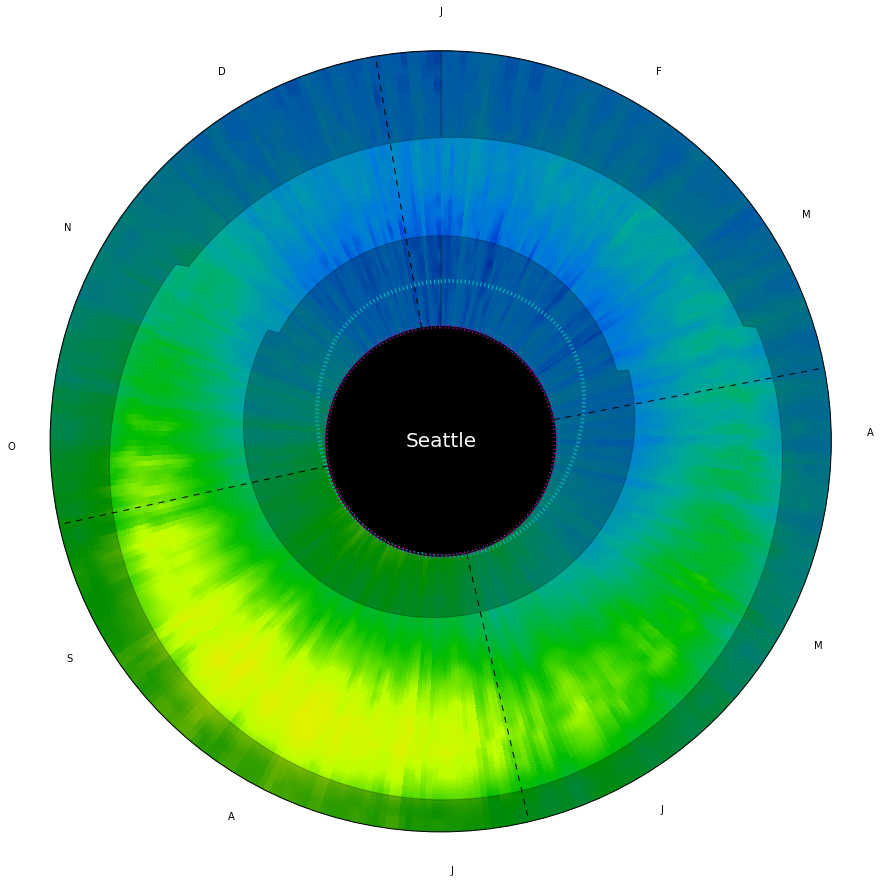

In [9]:
srise = np.array(sunrise)

dth = 2*np.pi/len(sunrise)
start = np.pi/2
theta = -np.linspace(0-start, 2*np.pi-start, len(sunrise)+1)
msize = 4
roffset = 10

fig = plt.figure(figsize=(14,14))
# fig.set_facecolor('black')
ax = plt.subplot(111, projection='polar')
ax.fill_between(theta, 0,roffset,facecolor='black')

# temperature
tmap = make_tmap()
tsmooth = smooth_temps(temps, s=1e4)
times = np.linspace(0,24,366)+roffset
ax.pcolormesh(theta,times,tsmooth, vmin=0,vmax=120,cmap=tmap)

# equinox/solstice
plot_equinoxes(ax, theta, roffset)

# sunrise and sunset
plot_daynight(ax, theta, sunrise, sunset, roffset, alpha=0.25)

# moonrise/set and phase
# plot_moon(ax, theta, moonrise, moonset, moonphase, roffset)

# precipitation
plot_line(ax, theta, precip_smooth*24, roffset, 'c:')
plot_line(ax, theta, snow_smooth*24, roffset, 'm:')

ax.plot(theta, np.ones_like(theta)*roffset,'k-')
ax.set_rmax(24+roffset)
ax.set_xticks(theta[monthstarts])
# ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'], )
# ax.set_xticklabels([])
# ax.xaxis.get_majorticklabels()

ax.set_yticks([x+roffset for x in [0,6,12,18,24]])
ax.set_yticklabels([])  
# ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(False)

# ax.set_title("Berkeley", fontsize=20)
ax.text(0,0,'Seattle',fontsize=20,horizontalalignment='center',verticalalignment='center', color='white')
plt.savefig('Seattle.png')
# plt.show()